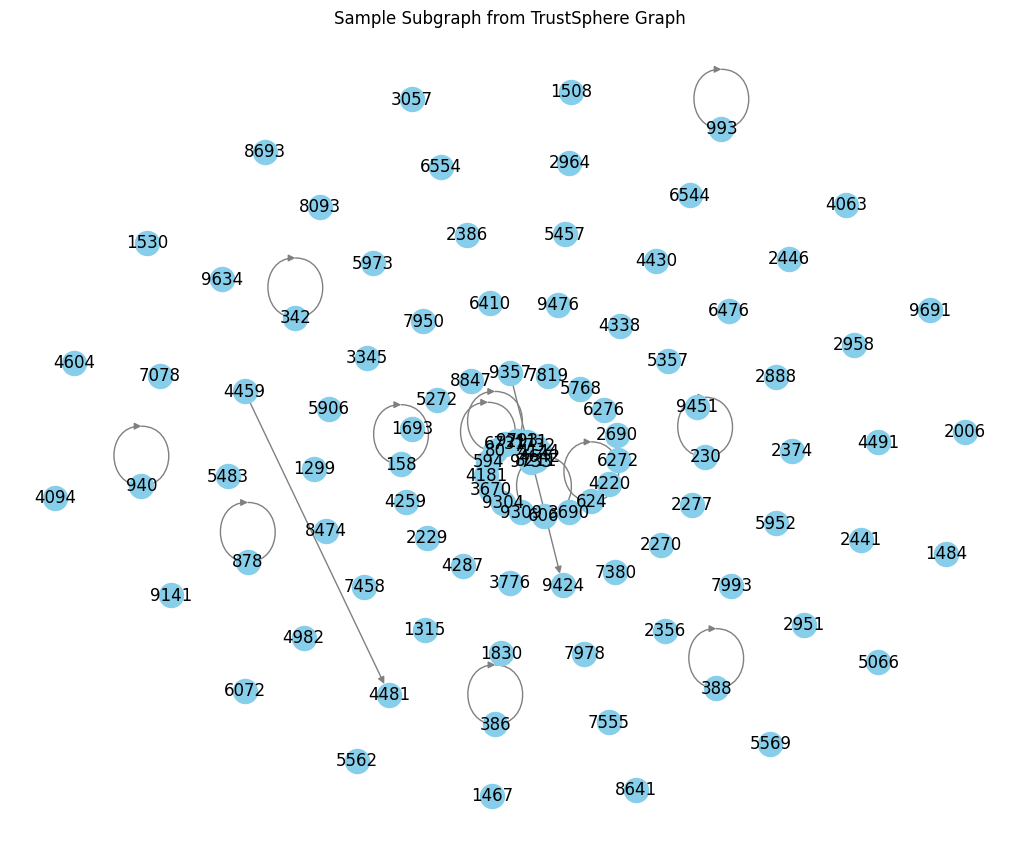

In [15]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import random

import torch
from torch_geometric.data import HeteroData
from torch.serialization import add_safe_globals

# Allow loading HeteroData objects
add_safe_globals({'HeteroData': HeteroData})

# Load the graph (if saved directly)
graph = torch.load("../hetero_graph.pt", weights_only=False)

# Visualize a specific edge type from HeteroData, e.g., ('reviewer', 'wrote', 'review')
edge_index = graph['reviewer', 'wrote', 'review'].edge_index

# Create a directed NetworkX graph
G_nx = nx.DiGraph()
src, dst = edge_index[0].tolist(), edge_index[1].tolist()
edges = list(zip(src, dst))
G_nx.add_edges_from(edges)

# Sample a small subgraph for visualization
nodes = list(G_nx.nodes)
sample_nodes = random.sample(nodes, min(100, len(nodes)))
subgraph = G_nx.subgraph(sample_nodes)

# Draw the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spiral_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Sample Subgraph from TrustSphere Graph")
plt.show()


Node types: ['product', 'reviewer', 'brand', 'category', 'review']
Edge types: [('reviewer', 'wrote', 'review'), ('review', 'about', 'product'), ('product', 'has_brand', 'brand'), ('product', 'in_category', 'category'), ('product', 'also_viewed', 'product')]


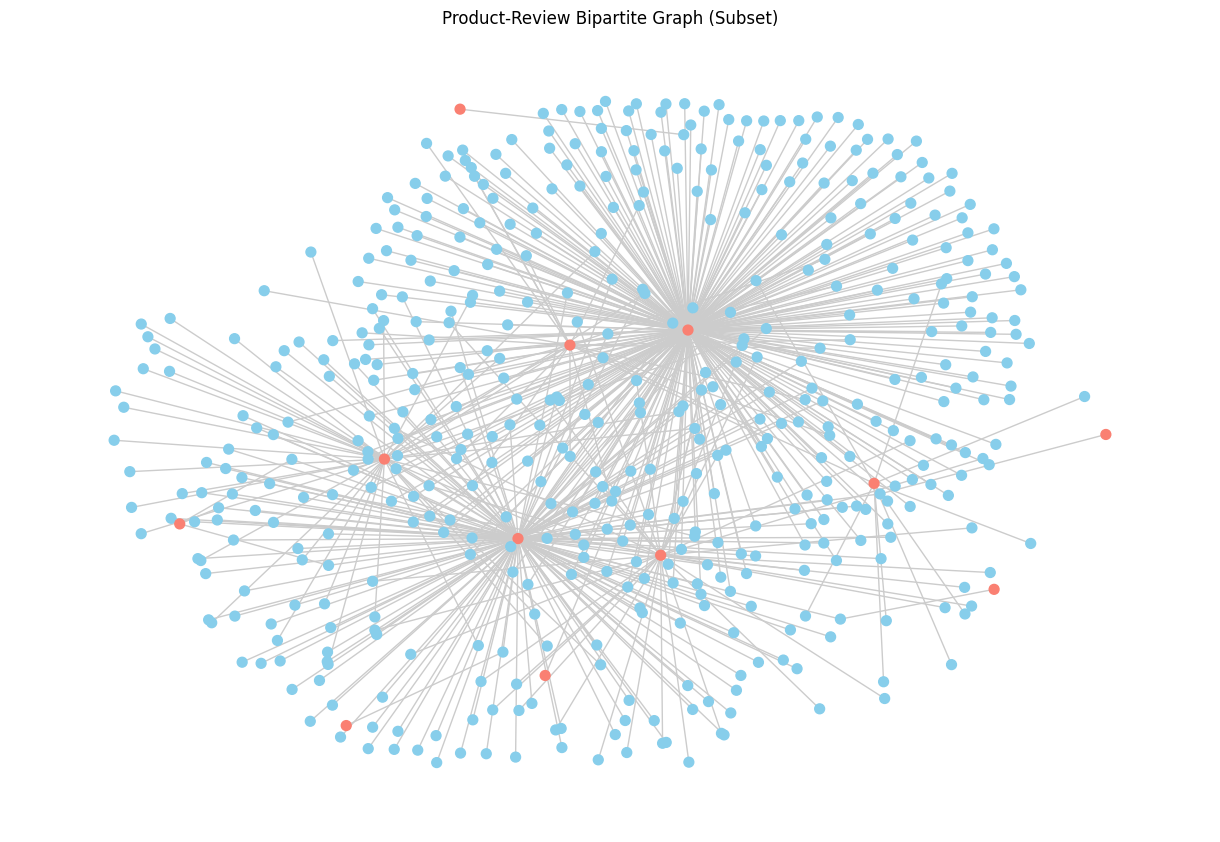

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import torch
from torch_geometric.data import HeteroData
from torch.serialization import add_safe_globals

# Allow loading HeteroData objects
add_safe_globals({'HeteroData': HeteroData})

# Load the saved graph
data = torch.load("../hetero_graph.pt", weights_only=False)
print("Node types:", data.node_types)
print("Edge types:", data.edge_types)

# Extract only review → product edges
edge_index = data[("review", "about", "product")].edge_index

# Build bipartite graph
G = nx.Graph()

# Add nodes for reviews and products
num_reviews = data["review"].num_nodes
num_products = data["product"].num_nodes

# Assign node labels for visualization
for i in range(num_reviews):
    G.add_node(f"r_{i}", type="review")
for j in range(num_products):
    G.add_node(f"p_{j}", type="product")

# Add edges between reviews and products
src_nodes, dst_nodes = edge_index
for src, dst in zip(src_nodes.tolist(), dst_nodes.tolist()):
    G.add_edge(f"r_{src}", f"p_{dst}")
    
max_edges = 500
G = G.edge_subgraph(list(G.edges)[:max_edges]).copy()

# Color nodes by type
colors = ["skyblue" if G.nodes[n]["type"] == "review" else "salmon" for n in G.nodes]

# Layout & draw
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.3)
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, edge_color="#cccccc")
plt.title("Product-Review Bipartite Graph (Subset)")
plt.show()


In [25]:

import torch
from torch_geometric.data import HeteroData
import random

# Seed for reproducibility
torch.manual_seed(42)
random.seed(42)

data = HeteroData()

# 5 reviewers with 16-dim random features
data['reviewer'].x = torch.randn(5, 16)
data['reviewer'].y = torch.tensor([1, 0, 1, 0, 1])  # Trust labels

# 7 reviews with 32-dim features
data['review'].x = torch.randn(7, 32)

# 4 products with 8-dim TFIDF-like features
data['product'].x = torch.randn(4, 8)

# 2 brands, 2 categories — one-hot
data['brand'].x = torch.eye(2)
data['category'].x = torch.eye(2)

# Edge connections
data['reviewer', 'wrote', 'review'].edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 0, 1],  # reviewer idx
    [0, 1, 2, 3, 4, 5, 6],  # review idx
], dtype=torch.long)

data['review', 'about', 'product'].edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 5, 6],  # review idx
    [0, 1, 2, 3, 1, 0, 2],  # product idx
], dtype=torch.long)

data['product', 'has_brand', 'brand'].edge_index = torch.tensor([
    [0, 1, 2, 3],
    [0, 1, 0, 1],
], dtype=torch.long)

data['product', 'in_category', 'category'].edge_index = torch.tensor([
    [0, 1, 2, 3],
    [1, 0, 1, 0],
], dtype=torch.long)

data['product', 'also_viewed', 'product'].edge_index = torch.tensor([
    [0, 1, 2],
    [1, 2, 3],
], dtype=torch.long)

# Train mask (e.g. 3 for training, 2 for validation)
train_mask = torch.tensor([1, 1, 1, 0, 0], dtype=torch.bool)
val_mask = ~train_mask
data['reviewer'].train_mask = train_mask
data['reviewer'].val_mask = val_mask

torch.save(data, "toy_trust_graph.pt")
print("✅ Sample toy heterogeneous graph saved to toy_trust_graph.pt")


✅ Sample toy heterogeneous graph saved to toy_trust_graph.pt


In [31]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import HeteroData
from torch_geometric.nn import RGCNConv
import os

# 1. Load the heterogeneous graph
GRAPH_PATH = "toy_trust_graph.pt"  # or "hetero_graph.pt"
assert os.path.exists(GRAPH_PATH), f"Graph file not found: {GRAPH_PATH}"
# If using PyTorch >=2.6 with safe globals needed, ensure you loaded appropriately.
data: HeteroData = torch.load(GRAPH_PATH, weights_only=False)

# 2. Determine device
device = torch.device('mps' if torch.backends.mps.is_available()
                      else 'cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3. Gather node types and counts, build offsets for global indexing
node_types = data.node_types  # e.g., ['reviewer','review','product','brand','category']
num_nodes_dict = {ntype: data[ntype].num_nodes for ntype in node_types}
offsets = {}
cum = 0
for ntype in node_types:
    offsets[ntype] = cum
    cum += num_nodes_dict[ntype]
num_total_nodes = cum
print("Node types and counts:", num_nodes_dict)
print("Total nodes:", num_total_nodes)

# 4. Create per-type Linear projections to a common hidden dim
HIDDEN_DIM = 64
lin_dict = nn.ModuleDict()
for ntype in node_types:
    in_dim = data[ntype].x.size(1)
    lin = nn.Linear(in_dim, HIDDEN_DIM)
    lin_dict[ntype] = lin

# Move projection layers to device
lin_dict = lin_dict.to(device)

# 5. Build unified edges and edge_type mapping once, move to device
edge_types = data.edge_types  # list of tuples (src, rel, dst)
rel_id_map = {etype: i for i, etype in enumerate(edge_types)}
num_relations = len(edge_types)
print("Relations and IDs:", rel_id_map)

edge_index_list = []
edge_type_list = []
for etype, rel_id in rel_id_map.items():
    src_type, rel_name, dst_type = etype
    edge_index = data[etype].edge_index  # [2, num_edges]
    # Convert to global indices
    src_off = offsets[src_type]
    dst_off = offsets[dst_type]
    src_global = edge_index[0] + src_off
    dst_global = edge_index[1] + dst_off
    # Directed edge as given:
    edge_index_list.append(torch.stack([src_global, dst_global], dim=0))
    edge_type_list.append(torch.full((src_global.size(0),), rel_id, dtype=torch.long))
    # If you want undirected: also append reverse edges here

# Concatenate all edges
edge_index_all = torch.cat(edge_index_list, dim=1)  # [2, E_total]
edge_type_all = torch.cat(edge_type_list, dim=0)    # [E_total]

# Move edge_index_all and edge_type_all to device
edge_index_all = edge_index_all.to(device)
edge_type_all = edge_type_all.to(device)

# 6. Prepare reviewer node global indices, labels, masks
num_reviewers = num_nodes_dict['reviewer']
rev_off = offsets['reviewer']
reviewer_global_idx = torch.arange(rev_off, rev_off + num_reviewers, device=device)

# Ensure labels exist
if 'y' not in data['reviewer']:
    raise RuntimeError("No labels found in data['reviewer'].y; add binary labels (0/1).")
labels = data['reviewer'].y.to(device)  # shape [num_reviewers]

# Masks
if 'train_mask' in data['reviewer']:
    train_mask = data['reviewer'].train_mask.to(device)
    val_mask = data['reviewer'].val_mask.to(device)
else:
    # Random 80/20 split
    perm = torch.randperm(num_reviewers, device=device)
    train_count = int(0.8 * num_reviewers)
    train_idx = perm[:train_count]
    val_idx = perm[train_count:]
    train_mask = torch.zeros(num_reviewers, dtype=torch.bool, device=device)
    val_mask = torch.zeros(num_reviewers, dtype=torch.bool, device=device)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    data['reviewer'].train_mask = train_mask
    data['reviewer'].val_mask = val_mask

# 7. Define a function to project all features each epoch
def project_all_features():
    """
    For each node type, move raw features to device, apply the corresponding lin_dict projection,
    then concatenate into x_all of shape [num_total_nodes, HIDDEN_DIM].
    """
    proj_feats = []
    for ntype in node_types:
        x = data[ntype].x.to(device)  # raw features on device
        x_proj = lin_dict[ntype](x)   # [num_nodes_of_type, HIDDEN_DIM]
        proj_feats.append(x_proj)
    x_all = torch.cat(proj_feats, dim=0)  # [num_total_nodes, HIDDEN_DIM]
    return x_all

# 8. Define RGCN model
class RGCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations=num_relations)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations=num_relations)
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_type):
        # x: [num_total_nodes, in_channels]
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        x = F.relu(x)
        return x  # embeddings for all nodes

# Instantiate model, move to device
IN_DIM = HIDDEN_DIM
HID_DIM = 64
OUT_DIM = 2  # binary classification
model = RGCNNet(in_channels=IN_DIM, hidden_channels=HID_DIM,
                out_channels=OUT_DIM, num_relations=num_relations).to(device)

# 9. Optimizer: include both lin_dict parameters and model parameters
optimizer = torch.optim.Adam(
    list(lin_dict.parameters()) + list(model.parameters()),
    lr=0.01, weight_decay=5e-4
)

# 10. Training & evaluation functions
def train():
    model.train()
    optimizer.zero_grad()
    # Recompute feature projections
    x_all = project_all_features()  # fresh graph for projection
    out_all = model(x_all, edge_index_all, edge_type_all)  # [num_total_nodes, HID_DIM]
    # Extract reviewer embeddings
    reviewer_out = out_all[reviewer_global_idx]            # [num_reviewers, HID_DIM]
    logits = model.classifier(reviewer_out)                # [num_reviewers, 2]
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(mask):
    model.eval()
    # Recompute feature projections
    x_all = project_all_features()
    out_all = model(x_all, edge_index_all, edge_type_all)
    reviewer_out = out_all[reviewer_global_idx]
    logits = model.classifier(reviewer_out)
    preds = logits.argmax(dim=1)
    correct = (preds[mask] == labels[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0

# 11. Run training loop
EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    loss = train()
    val_acc = evaluate(val_mask)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

# 12. After training: obtain reviewer embeddings or predictions
with torch.no_grad():
    x_all = project_all_features()
    out_all = model(x_all, edge_index_all, edge_type_all)
    reviewer_embeds = out_all[reviewer_global_idx]        # [num_reviewers, HID_DIM]
    reviewer_logits = model.classifier(reviewer_embeds)   # [num_reviewers, 2]
    reviewer_preds = reviewer_logits.argmax(dim=1)
print("Training complete. Sample reviewer preds:", reviewer_preds[:10])


Using device: mps
Node types and counts: {'reviewer': 5, 'review': 7, 'product': 4, 'brand': 2, 'category': 2}
Total nodes: 20
Relations and IDs: {('reviewer', 'wrote', 'review'): 0, ('review', 'about', 'product'): 1, ('product', 'has_brand', 'brand'): 2, ('product', 'in_category', 'category'): 3, ('product', 'also_viewed', 'product'): 4}
Epoch 01 | Loss: 0.7787 | Val Acc: 0.0000
Epoch 02 | Loss: 0.3916 | Val Acc: 0.5000
Epoch 03 | Loss: 0.1563 | Val Acc: 0.5000
Epoch 04 | Loss: 0.0448 | Val Acc: 0.5000
Epoch 05 | Loss: 0.0096 | Val Acc: 0.5000
Epoch 06 | Loss: 0.0017 | Val Acc: 0.5000
Epoch 07 | Loss: 0.0002 | Val Acc: 0.5000
Epoch 08 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 09 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 10 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 11 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 12 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 13 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 14 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 15 | Loss: 0.0000 | Val Acc: 0.5000
Epoch 16 | Loss: 0.0000 | Val

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, DeepGraphInfomax
from torch_geometric.data import Data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = torch.load("../hetero_graph.pt", weights_only=False)

# Convert your reviewer subgraph into homogeneous format
reviewer_idx = torch.arange(data['reviewer'].num_nodes)
reviewer_x = data['reviewer'].x
edges = data[('reviewer', 'wrote', 'review')].edge_index

# Convert review -> product -> other reviewers as co-engagement (optional)
# For now, we build a homogeneous graph of reviewers with identity features
# You can optionally use reviewer-review-product-reviewer co-engagement

# Simple graph for illustration (you can expand this with co-engagement)
reviewer_data = Data(x=reviewer_x, edge_index=edges)

# DGI encoder
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return x, x

encoder = Encoder(reviewer_x.size(1), hidden_channels=64)

# DGI model
model = DeepGraphInfomax(
    hidden_channels=64,
    encoder=encoder,
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=lambda x, edge_index: (x[torch.randperm(x.size(0))], edge_index),
).to(reviewer_x.device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train DGI
model.train()
for epoch in range(1, 101):
    optimizer.zero_grad()
    pos_z, neg_z, summary = model(reviewer_data.x, reviewer_data.edge_index)
    loss = model.loss(pos_z, neg_z, summary)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Get reviewer embeddings
model.eval()
embeddings, _ = model.encoder(reviewer_data.x, reviewer_data.edge_index)
print("Learned reviewer embeddings shape:", embeddings.shape)

# Optional: t-SNE visualization
tsne = TSNE(n_components=2)
embed_2d = tsne.fit_transform(embeddings.cpu().detach().numpy())

plt.figure(figsize=(6, 6))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], s=5)
plt.title("Reviewer Embeddings via Deep Graph Infomax")
plt.show()


RuntimeError: index 9832 is out of bounds for dimension 0 with size 9832